In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import pmdarima.arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('Impute_misvalues_hungyen.csv')
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,0,47.0
1,1/1/2008,1,43.0
2,1/1/2008,2,40.0
3,1/1/2008,3,37.0
4,1/1/2008,4,34.0


In [3]:
df['Hour'] = df['Hour'].replace('#NUM!', 0)

In [4]:
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,00:00:00,47.0
1,1/1/2008,01:00:00,43.0
2,1/1/2008,02:00:00,40.0
3,1/1/2008,03:00:00,37.0
4,1/1/2008,04:00:00,34.0


In [5]:
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


In [6]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size].iloc[:, [-1]], df[train_size:].iloc[:, [-1]]

train, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2015-04-23 00:00:00       127.0
 2015-04-23 01:00:00       124.0
 2015-04-23 02:00:00       120.0
 2015-04-23 03:00:00       115.0
 2015-04-23 04:00:00       109.0
 
 [19219 rows x 1 columns])

In [7]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)
test['Waterlevel'] = scaler.transform(test)

In [8]:
train_data = train.values
test_data = test.values

In [9]:
timesteps = 164


In [10]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [11]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.10782866, 0.10192024, 0.09748892, ..., 0.17282127, 0.16395864,
         0.15509601],
        [0.10192024, 0.09748892, 0.09305761, ..., 0.16395864, 0.15509601,
         0.14623338],
        [0.09748892, 0.09305761, 0.08862629, ..., 0.15509601, 0.14623338,
         0.13737075],
        ...,
        [0.1816839 , 0.17725258, 0.17282127, ..., 0.14327917, 0.16543575,
         0.18611521],
        [0.17725258, 0.17282127, 0.16838996, ..., 0.16543575, 0.18611521,
         0.20827179],
        [0.17282127, 0.16838996, 0.16395864, ..., 0.18611521, 0.20827179,
         0.22747415]]),
 array([[0.14623338],
        [0.13737075],
        [0.12998523],
        ...,
        [0.20827179],
        [0.22747415],
        [0.23633678]]))

In [12]:
y_train.shape

(44679, 1)

In [13]:
hours = 120
def forecast_value_test (model, hours):
    current_window = x_train[-1,:].tolist()

    predict = []

    for _ in range(hours):
        next_value = model.predict([current_window])[0]
        predict.append(next_value)
        
        current_window.pop(0)  
        current_window.append(next_value)
    predict_array = np.array(predict).reshape(-1, 1)
    return(predict_array)
   

In [14]:
def forecast_value_train (model):
    current_window = x_train[1,:164].tolist()

    predict = []

    for _ in range(len(x_train - 163)):
        next_value = model.predict([current_window])[0]
        predict.append(next_value)
        
        current_window.pop(0)  
        current_window.append(next_value)
    predict_array = np.array(predict).reshape(-1, 1)
    return(predict_array)

In [15]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(x_train, y_train[:,0])

KNeighborsRegressor()

In [16]:
predict_KNN_test = forecast_value_test(knn_regressor, hours)
predict_KNN_test.shape

(120, 1)

In [17]:
predict_KNN_train = knn_regressor.predict(x_train)

In [18]:
predict_KNN_train.shape

(44679,)

In [19]:
y_test_pred = scaler.inverse_transform(predict_KNN_test)
y_train_pred = scaler.inverse_transform(predict_KNN_train.reshape(-1,1))
y_train_original = scaler.inverse_transform(y_train)
y_test_original = scaler.inverse_transform(y_test)

In [20]:
res_train_KNN = y_train_original.flatten() - y_train_pred.flatten()
res_train_KNN.shape

(44679,)

In [21]:
res_test_KNN = y_test_original.flatten()[:120] - y_test_pred.flatten()
res_test_KNN.shape

(120,)

In [22]:
res_train_KNN

array([-2.4,  1. ,  2. , ..., -7.4,  1.8, -1.6])

In [23]:
res_train_KNN_m = res_train_KNN.reshape(-1,1)


In [24]:
warnings.filterwarnings(category=UserWarning, action='ignore')
arima_model = pmdarima.arima.auto_arima(res_train_KNN_m, seasonal=False, 
                                        error_action='ignore', trace=True,
                                        suppress_warnings=True, maxiter=20, stepwise=True,
                                          n_jobs=2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=176893.714, Time=29.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=179613.009, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179222.881, Time=1.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=179199.519, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=179611.009, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=176545.115, Time=17.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=179186.926, Time=4.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=179195.990, Time=7.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=17.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=178913.123, Time=7.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=177516.078, Time=17.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=176527.322, Time=30.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=34.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=176406.734, Time=29.15 sec
 ARIMA(1,1,4

In [25]:
predictions_arima = arima_model.predict(n_periods = 120)
predictions_arima.shape

(120,)

In [26]:
predictions_arima

array([-1.80628631, -2.03969436, -2.1163002 , -2.06669428, -2.02538723,
       -1.99092801, -1.96211931, -1.93797314, -1.91767427, -1.90055002,
       -1.8860453 , -1.8737021 , -1.86314249, -1.85405461, -1.84618113,
       -1.83930972, -1.83326517, -1.8279029 , -1.82310362, -1.81876889,
       -1.81481748, -1.81118238, -1.80780828, -1.80464954, -1.80166851,
       -1.79883412, -1.79612072, -1.79350716, -1.79097599, -1.78851279,
       -1.78610569, -1.78374488, -1.78142225, -1.77913115, -1.77686604,
       -1.7746224 , -1.77239646, -1.77018513, -1.76798586, -1.76579653,
       -1.76361541, -1.76144107, -1.75927231, -1.75710817, -1.75494783,
       -1.75279063, -1.75063603, -1.74848356, -1.74633285, -1.7441836 ,
       -1.74203555, -1.73988849, -1.73774225, -1.73559669, -1.73345168,
       -1.73130713, -1.72916296, -1.72701911, -1.72487551, -1.72273212,
       -1.72058891, -1.71844585, -1.7163029 , -1.71416006, -1.71201729,
       -1.7098746 , -1.70773195, -1.70558936, -1.7034468 , -1.70

In [27]:
y_test_pred.shape

(120, 1)

In [28]:
final_pred = y_test_pred.reshape(-1,1).flatten() + predictions_arima.reshape(-1,1).flatten()
final_pred

array([133.79371369, 139.96030564, 141.6836998 , 137.33330572,
       131.57461277, 125.60907199, 117.03788069, 110.86202686,
       104.08232573,  97.29944998,  90.6139547 ,  83.7262979 ,
        71.53685751,  64.14594539,  57.25381887,  50.56069028,
        45.16673483,  41.7720971 ,  45.77689638,  55.78123111,
        70.58518252,  83.38881762,  94.19219172, 102.59535046,
       109.99833149, 107.80116588, 108.40387928, 105.40649284,
       100.00902401,  93.41148721,  92.61389431,  86.41625512,
        81.01857775,  75.42086885,  68.62313396,  62.0253776 ,
        56.42760354,  51.22981487,  46.03201414,  40.63420347,
        36.03638459,  26.03855893,  29.24072769,  37.44289183,
        48.04505217,  58.44720937,  75.84936397,  86.45151644,
        96.05366715, 103.6558164 , 107.85796445, 107.86011151,
       103.46225775,  97.26440331,  91.06654832,  85.06869287,
        78.67083704,  70.27298089,  64.57512449,  58.47726788,
        52.87941109,  47.68155415,  42.3836971 ,  36.98

In [29]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r, _ = pearsonr(y_true, y_pred)
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }

In [30]:
metrics_ARIMA = calculate_metrics(scaler.inverse_transform(test_data[:hours]).flatten(), final_pred[:hours].flatten())
for metric, value in metrics_ARIMA.items():
    print(f'Using model ARIMA {metric}: {value}')

Using model ARIMA MAE: 10.571664737116517
Using model ARIMA RMSE: 13.75303571795084
Using model ARIMA R: 0.924650480309685
Using model ARIMA SIM: 0.9246088302360533
Using model ARIMA FSD: 1.9863380131858532
Using model ARIMA NSE: 0.7751897145634853


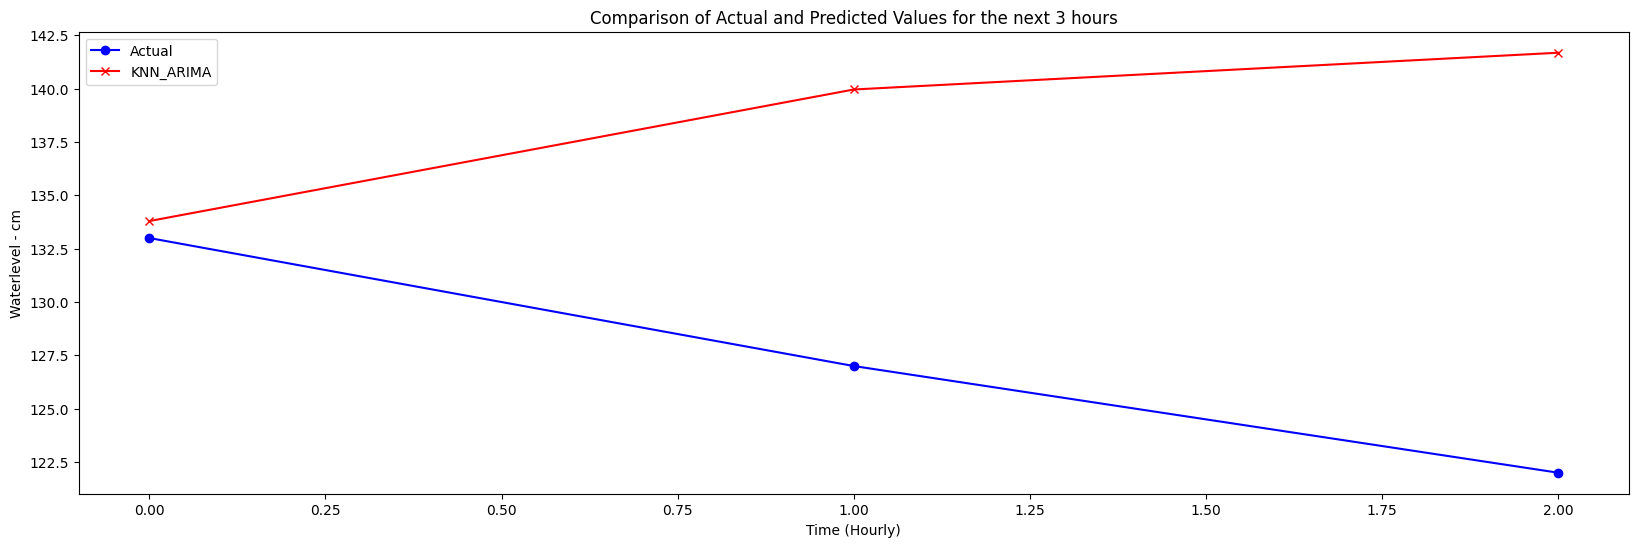

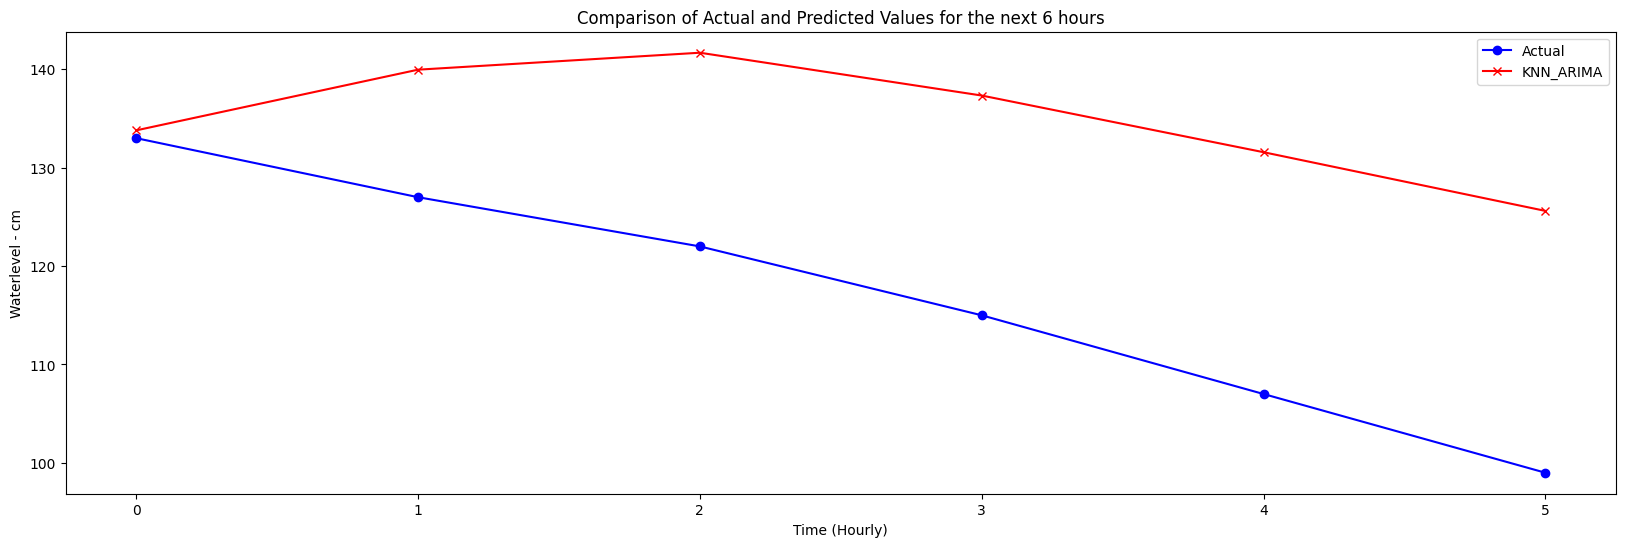

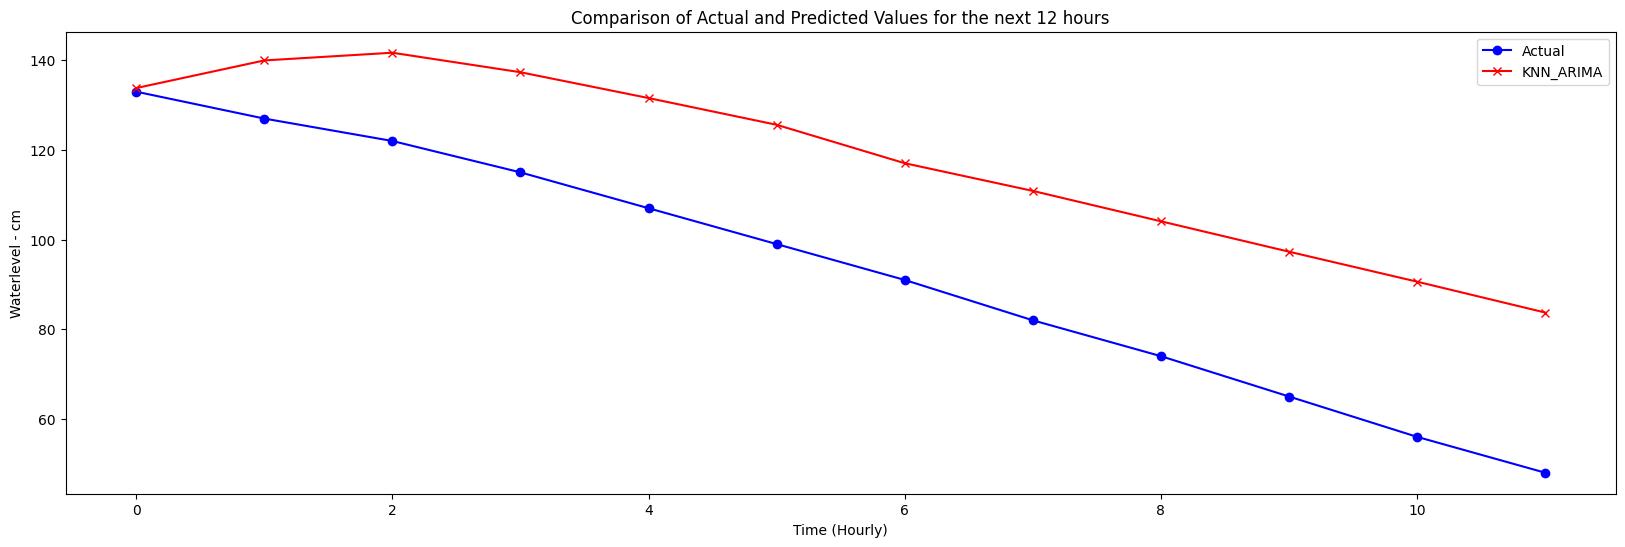

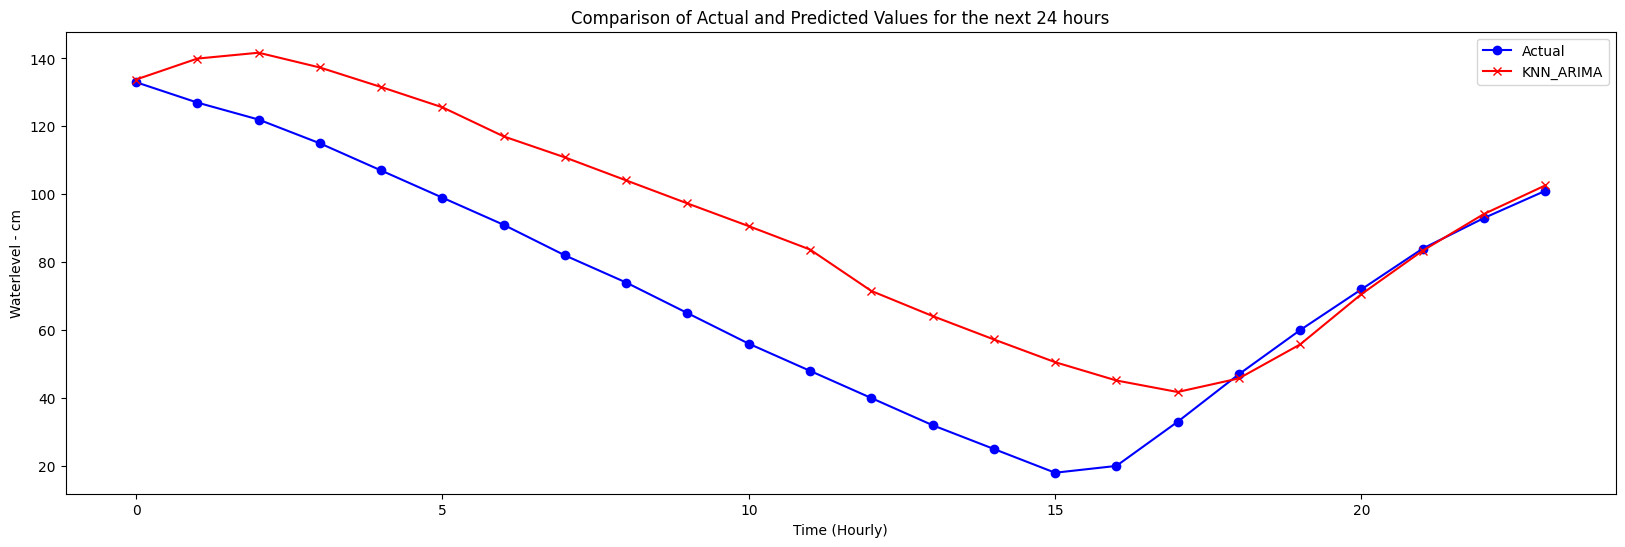

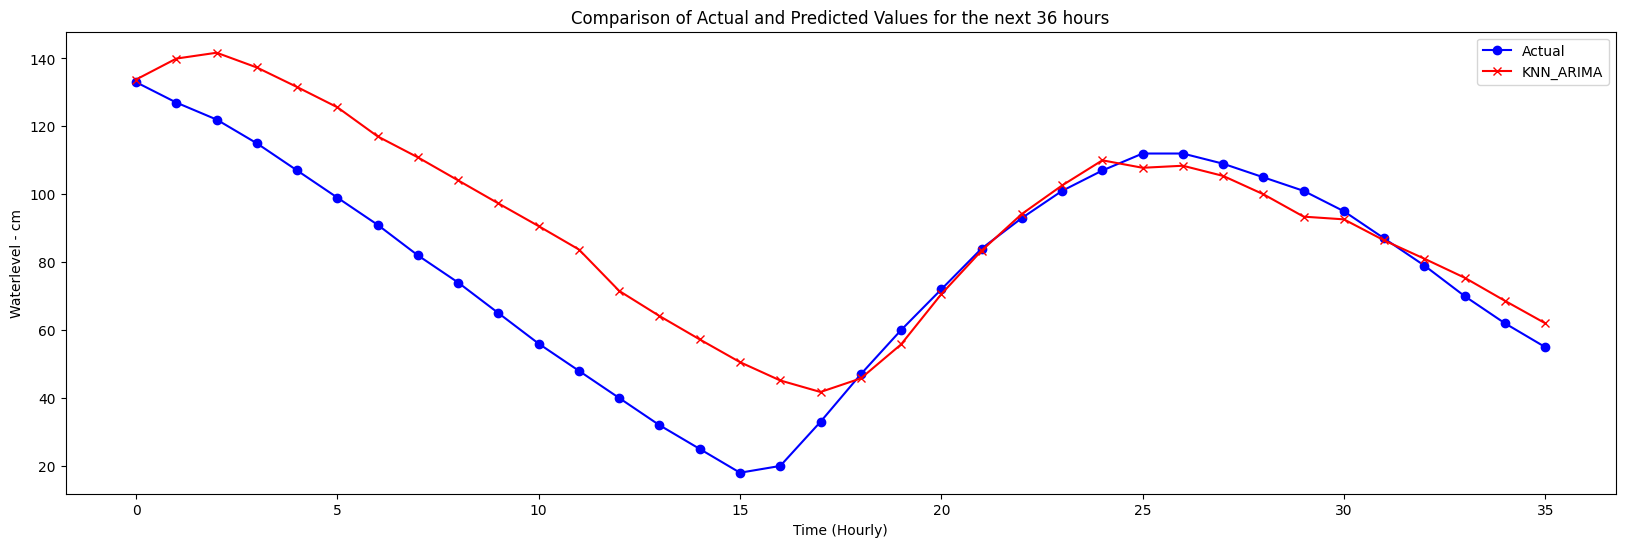

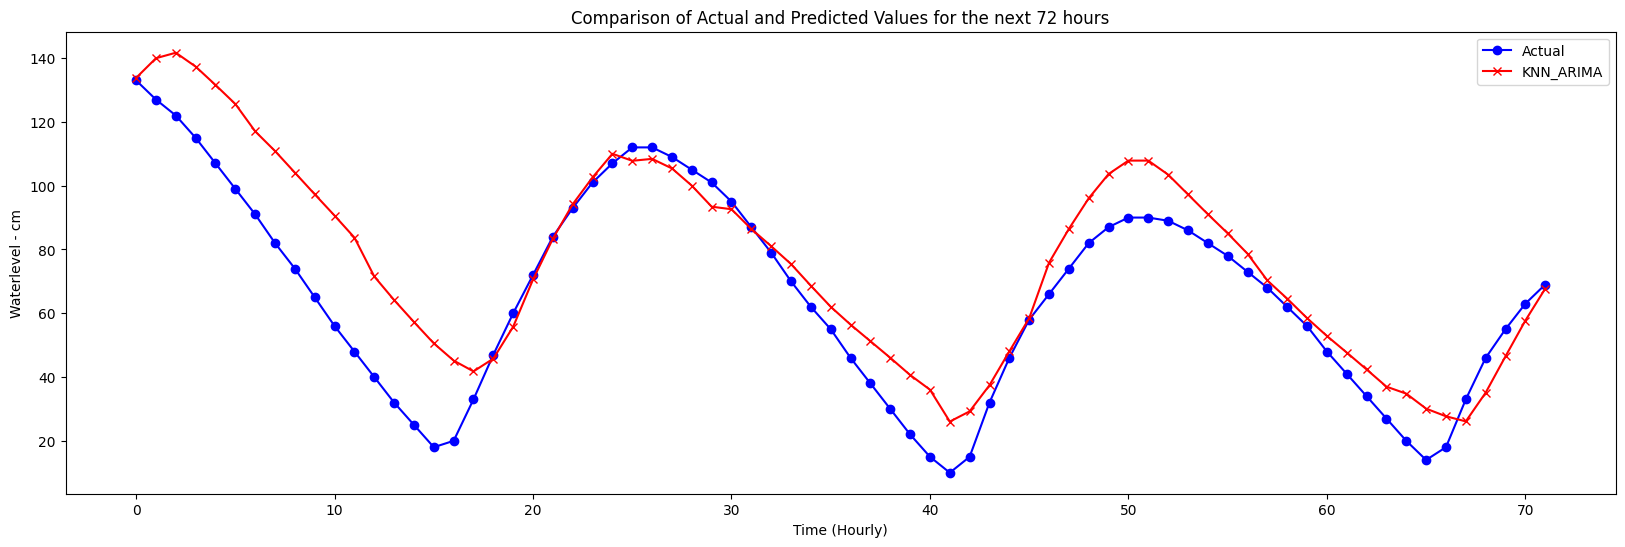

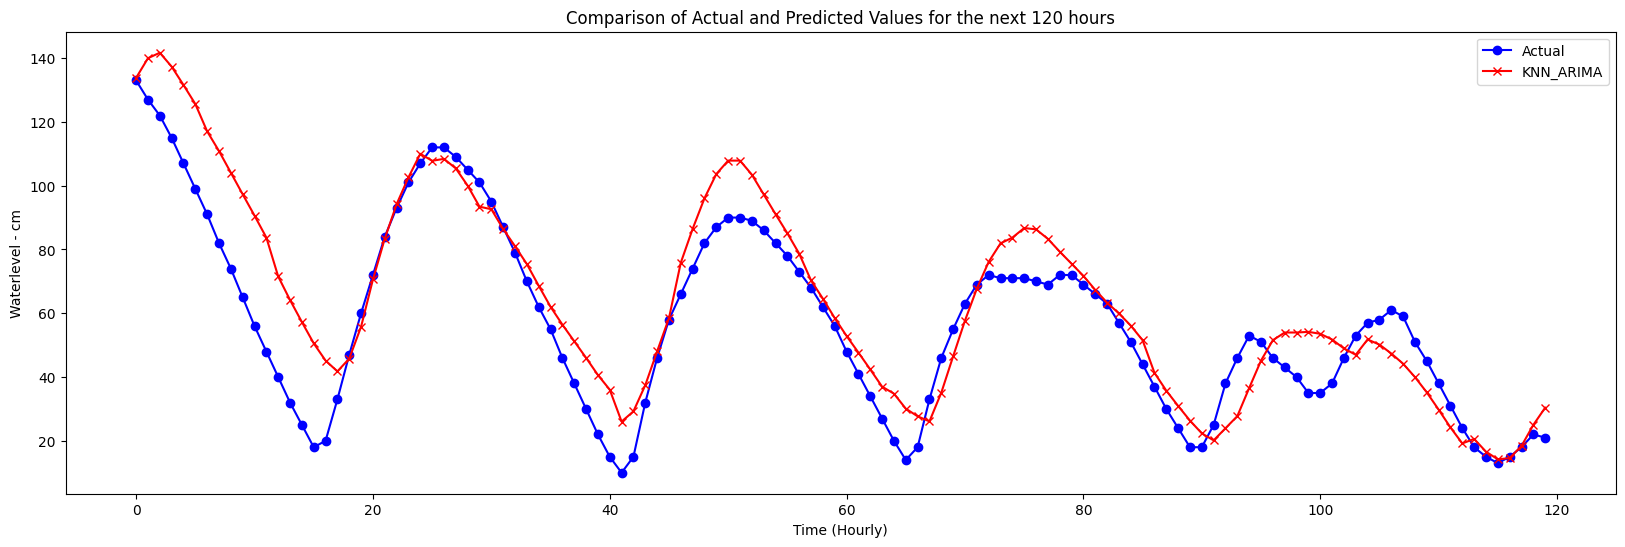

In [31]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(scaler.inverse_transform(test_data[:hours]), label='Actual', color='blue', marker='o')
    plt.plot(final_pred[:hours], label='KNN_ARIMA', color='red', marker='x')
    
    
    plt.title(f'Comparison of Actual and Predicted Values for the next {hours} hours')
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Waterlevel - cm')
    plt.legend()

    plt.show()